# **Discount Effectiveness Analysis**
The third task in BDA project
## 🌍 **Task Goal**

**Understand and evaluate how discounts affect sales across different countries.**

- Identify **optimal discount thresholds** that **maximize order quantities and sales revenue**.
- Determine how different **regions react to discounts**, and **avoid over-discounting**.
- Derive actionable **country-specific discount strategies**.

## **🔃Loading the Data**

In [ ]:
# importing necessary libraries
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Creatingn a spark session app
spark = SparkSession.builder.appName('Discount_Effectiveness').getOrCreate()

In [ ]:
# importing data
data = spark.read.csv('DataCoSupplyChainDataset.csv', header=True, inferSchema=True)

In [ ]:
data.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

In [ ]:
data.describe().show()

+-------+--------+------------------------+-----------------------------+------------------+------------------+----------------+-------------------+------------------+------------------+-------------+----------------+--------------+--------------+-----------------+--------------+-----------------+----------------+------------------+---------------+-----------------+------------------+---------------+------------------+-----------------+------+--------------+-------------+-----------------+-----------------------+-----------------+----------------------+-------------------+------------------------+-----------------+------------------------+-----------------------+-------------------+------------------+------------------+----------------------+--------------+--------------+---------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------+--------------------------+--------------+
|summ

### Must Keep Columns
- Order Item Quantity
- Order Item Discount Rate
- Sales or Order Item Total
- Order Item Product Price
- Order Country or Customer Country
- Order Date
- Product Category Id or Department Name
-Order Id
### Keep Just In Case
- Order Region/ Order State
- Late delivery risk
- Shipping Mode
- Order Item Profit Ratio
- Customer Segment
- Product Status
- Order Status
- Product Price


In [ ]:
# Dropping Unnecessary Columns
columns_to_drop = [
    "Customer Email", "Customer Fname", "Customer Lname", "Customer Password",
    "Customer Street", "Customer Zipcode", "Order Zipcode",
    "Latitude", "Longitude",
    "Product Description", "Product Image", "Product Name",
    "Product Card Id", "Product Category Id", "Order Item Cardprod Id",
    "Order Customer Id", "Customer Id", "Order Item Id",
    "Department Id", "Category Id"
]

data = data.drop(*columns_to_drop)
data.printSchema()



root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Market: string (nullable = true)
 |-- Order City: string (nullable = true)
 |-- Order Country: string (nullable = true)
 |-- order date (DateOrders): string (nullable = true)
 |-- Order Id: integer (nullable = true)
 |-- Order Item Discount: double (nullable = true)
 |-- Order Item Discount Rate: double (nullable = true)
 |-- Order Item Product Price: doubl

In [ ]:
# Strip whitespace from column names
data = data.toDF(*[col.strip() for col in data.columns])


# **🔎Exploratory Data Analysis**



## **🧹Cleaning**

In [ ]:
data.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Market: string (nullable = true)
 |-- Order City: string (nullable = true)
 |-- Order Country: string (nullable = true)
 |-- order date (DateOrders): string (nullable = true)
 |-- Order Id: integer (nullable = true)
 |-- Order Item Discount: double (nullable = true)
 |-- Order Item Discount Rate: double (nullable = true)
 |-- Order Item Product Price: doubl

In [ ]:
data.show(5,truncate=False)

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+--------------+-------------+----------------+----------------+--------------+---------------+------------+----------+-------------+-----------------------+--------+-------------------+------------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+--------------+--------------------------+--------------+
|Type    |Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status |Late_delivery_risk|Category Name |Customer City|Customer Country|Customer Segment|Customer State|Department Name|Market      |Order City|Order Country|order date (DateOrders)|Order Id|Order Item Discount|Order Item Discount Rate|Order Item Product Price|Order Item Profit Ratio|Order Item Quantity|

In [ ]:
# Checking Null Values
from pyspark.sql.functions import col, sum as spark_sum

important_cols = [
    "Order Item Quantity", "Order Item Discount Rate",
    "Order Item Product Price", "Sales", "Order Country"
]

data.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in important_cols]).show()


+-------------------+------------------------+------------------------+-----+-------------+
|Order Item Quantity|Order Item Discount Rate|Order Item Product Price|Sales|Order Country|
+-------------------+------------------------+------------------------+-----+-------------+
|                  0|                       0|                       0|    0|            0|
+-------------------+------------------------+------------------------+-----+-------------+



In [ ]:
# Duplicates
data.count(), data.dropDuplicates().count()

(180519, 180519)

In [ ]:
# Outliers and Invalid Values
data.filter(col("Order Item Quantity") <= 0).show()
data.filter((col("Order Item Discount Rate") < 0) | (col("Order Item Discount Rate") > 1)).show()

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-------------+-------------+----------------+----------------+--------------+---------------+------+----------+-------------+-----------------------+--------+-------------------+------------------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Category Name|Customer City|Customer Country|Customer Segment|Customer State|Department Name|Market|Order City|Order Country|order date (DateOrders)|Order Id|Order Item Discount|Order Item Discount Rate|Order Item Product Price|Order Item Profit Ratio|Order Item Quantity|Sales|Order Item Total|Order Profit

In [ ]:
# Consistency in Countries
data.select(("Order Country")).distinct().show()


+--------------------+
|       Order Country|
+--------------------+
|          Luxemburgo|
|            Paraguay|
|              Panam�|
|               Yemen|
|           Banglad�s|
|             Senegal|
|     Costa de Marfil|
|               Suiza|
|Rep�blica Democr�...|
|               Kenia|
|              Guyana|
|              Egipto|
|       Nueva Zelanda|
|             Croacia|
|             Eritrea|
|             Surinam|
|          Kazajist�n|
|              Bar�in|
|       Sud�n del Sur|
|              Italia|
+--------------------+
only showing top 20 rows



In [ ]:
!pip install unidecode
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import unidecode

# Define a UDF to normalize country names
@udf(StringType())
def normalize_text(text):
    if text:
        return unidecode.unidecode(text)
    return None

# Apply normalization to 'Order Country'
data = data.withColumn("Order Country", normalize_text("Order Country"))


In [ ]:
from pyspark.sql.functions import trim

data = data.withColumn("Order Country", trim(col("Order Country")))


In [ ]:
data.select("Order Country").distinct().orderBy("Order Country").show(100, truncate=False)


+---------------------+
|Order Country        |
+---------------------+
|Afganistn            |
|Albania              |
|Alemania             |
|Angola               |
|Arabia Saud          |
|Argelia              |
|Argentina            |
|Armenia              |
|Australia            |
|Austria              |
|Azerbaiyn            |
|Banglads             |
|Barbados             |
|Barin                |
|Belice               |
|Benn                 |
|Bielorrusia          |
|Blgica               |
|Bolivia              |
|Bosnia y Herzegovina |
|Botsuana             |
|Brasil               |
|Bulgaria             |
|Burkina Faso         |
|Burundi              |
|Butn                 |
|Camboya              |
|Camern               |
|Canada               |
|Chad                 |
|Chile                |
|China                |
|Chipre               |
|Colombia             |
|Corea del Sur        |
|Costa Rica           |
|Costa de Marfil      |
|Croacia              |
|Cuba           

In [ ]:
# prompt: count distinct values in country using pyspark

from pyspark.sql.functions import countDistinct

distinct_countries = data.select(countDistinct("Order Country")).collect()[0][0]
print(f"Number of distinct countries: {distinct_countries}")


Number of distinct countries: 164


In [ ]:
distinct_countries_list = [row['Order Country'] for row in data.select('Order Country').distinct().collect()]
for country in distinct_countries_list:
  print(country)


Luxemburgo
Paraguay
Azerbaiyn
Repblica Centroafricana
Yemen
Senegal
Costa de Marfil
Suiza
Repblica Democrtica del Congo
Kenia
Guyana
Egipto
Nueva Zelanda
Croacia
Eritrea
Surinam
Italia
Francia
Japn
Taiwn
Lesoto
Omn
Guinea Ecuatorial
Uzbekistn
Arabia Saud
Camern
Afganistn
Sri Lanka
Filipinas
Guadalupe
Togo
Sudn
Corea del Sur
Argentina
Jordania
Angola
Finlandia
Ecuador
Eslovaquia
Qatar
Zimbabue
Madagascar
Albania
Emiratos rabes Unidos
Nicaragua
SudAfrica
Ghana
Siria
India
China
Kuwait
Butn
Botsuana
Somalia
Ruanda
Chipre
Benn
Chile
Papa Nueva Guinea
Eslovenia
Alemania
Rusia
Burundi
Belice
Nigeria
Bolivia
Irak
Suazilandia
Cuba
Rumania
Mauritania
Trinidad y Tobago
Kazajistn
Barbados
Lbano
Guayana Francesa
Hungra
Laos
Barin
Per
Bielorrusia
Hong Kong
Grecia
Venezuela
Tailandia
Israel
Martinica
Gabn
Pakistn
Sudn del Sur
Uruguay
Repblica de Gambia
Georgia
Montenegro
Estonia
Indonesia
Kirguistn
Mongolia
Guatemala
Repblica Checa
Sierra Leona
Lituania
Pases Bajos
Repblica Dominicana
Armenia
Panam


In [ ]:
# The country names are in spanish
# to convert them in English
# Mapping Spanish: English
country_mapping = {
    "Luxemburgo": "Luxembourg",
    "Paraguay": "Paraguay",
    "Azerbaiyn": "Azerbaijan",
    "Repblica Centroafricana": "Central African Republic",
    "Yemen": "Yemen",
    "Senegal": "Senegal",
    "Costa de Marfil": "Ivory Coast",
    "Suiza": "Switzerland",
    "Repblica Democrtica del Congo": "Democratic Republic of the Congo",
    "Kenia": "Kenya",
    "Guyana": "Guyana",
    "Egipto": "Egypt",
    "Nueva Zelanda": "New Zealand",
    "Croacia": "Croatia",
    "Eritrea": "Eritrea",
    "Surinam": "Suriname",
    "Italia": "Italy",
    "Francia": "France",
    "Japn": "Japan",
    "Taiwn": "Taiwan",
    "Lesoto": "Lesotho",
    "Omn": "Oman",
    "Guinea Ecuatorial": "Equatorial Guinea",
    "Uzbekistn": "Uzbekistan",
    "Arabia Saud": "Saudi Arabia",
    "Camern": "Cameroon",
    "Afganistn": "Afghanistan",
    "Sri Lanka": "Sri Lanka",
    "Filipinas": "Philippines",
    "Guadalupe": "Guadeloupe",
    "Togo": "Togo",
    "Sudn": "Sudan",
    "Corea del Sur": "South Korea",
    "Argentina": "Argentina",
    "Jordania": "Jordan",
    "Angola": "Angola",
    "Finlandia": "Finland",
    "Ecuador": "Ecuador",
    "Eslovaquia": "Slovakia",
    "Qatar": "Qatar",
    "Zimbabue": "Zimbabwe",
    "Madagascar": "Madagascar",
    "Albania": "Albania",
    "Emiratos rabes Unidos": "United Arab Emirates",
    "Nicaragua": "Nicaragua",
    "SudAfrica": "South Africa",
    "Ghana": "Ghana",
    "Siria": "Syria",
    "India": "India",
    "China": "China",
    "Kuwait": "Kuwait",
    "Butn": "Bhutan",
    "Botsuana": "Botswana",
    "Somalia": "Somalia",
    "Ruanda": "Rwanda",
    "Chipre": "Cyprus",
    "Benn": "Benin",
    "Chile": "Chile",
    "Papa Nueva Guinea": "Papua New Guinea",
    "Eslovenia": "Slovenia",
    "Alemania": "Germany",
    "Rusia": "Russia",
    "Burundi": "Burundi",
    "Belice": "Belize",
    "Nigeria": "Nigeria",
    "Bolivia": "Bolivia",
    "Irak": "Iraq",
    "Suazilandia": "Eswatini",
    "Cuba": "Cuba",
    "Rumania": "Romania",
    "Mauritania": "Mauritania",
    "Trinidad y Tobago": "Trinidad and Tobago",
    "Kazajistn": "Kazakhstan",
    "Barbados": "Barbados",
    "Lbano": "Lebanon",
    "Guayana Francesa": "French Guiana",
    "Hungra": "Hungary",
    "Laos": "Laos",
    "Barin": "Bahrain",
    "Per": "Peru",
    "Bielorrusia": "Belarus",
    "Hong Kong": "Hong Kong",
    "Grecia": "Greece",
    "Venezuela": "Venezuela",
    "Tailandia": "Thailand",
    "Israel": "Israel",
    "Martinica": "Martinique",
    "Gabn": "Gabon",
    "Pakistn": "Pakistan",
    "Sudn del Sur": "South Sudan",
    "Uruguay": "Uruguay",
    "Repblica de Gambia": "Republic of the Gambia",
    "Georgia": "Georgia",
    "Montenegro": "Montenegro",
    "Estonia": "Estonia",
    "Indonesia": "Indonesia",
    "Kirguistn": "Kyrgyzstan",
    "Mongolia": "Mongolia",
    "Guatemala": "Guatemala",
    "Repblica Checa": "Czech Republic",
    "Sierra Leona": "Sierra Leone",
    "Lituania": "Lithuania",
    "Pases Bajos": "Netherlands",
    "Repblica Dominicana": "Dominican Republic",
    "Armenia": "Armenia",
    "Panam": "Panama",
    "Liberia": "Liberia",
    "Honduras": "Honduras",
    "Uganda": "Uganda",
    "Hait": "Haiti",
    "Singapur": "Singapore",
    "Yibuti": "Djibouti",
    "Namibia": "Namibia",
    "Zambia": "Zambia",
    "Tayikistn": "Tajikistan",
    "Irn": "Iran",
    "Jamaica": "Jamaica",
    "Myanmar (Birmania)": "Myanmar",
    "Guinea": "Guinea",
    "Banglads": "Bangladesh",
    "Mxico": "Mexico",
    "Canada": "Canada",
    "Macedonia": "North Macedonia",
    "Mozambique": "Mozambique",
    "Etiopa": "Ethiopia",
    "Bosnia y Herzegovina": "Bosnia and Herzegovina",
    "Estados Unidos": "United States",
    "Tnez": "Tunisia",
    "Tanzania": "Tanzania",
    "Espaa": "Spain",
    "Dinamarca": "Denmark",
    "Repblica del Congo": "Republic of the Congo",
    "Irlanda": "Ireland",
    "Noruega": "Norway",
    "Reino Unido": "United Kingdom",
    "Brasil": "Brazil",
    "Portugal": "Portugal",
    "Australia": "Australia",
    "Guinea-Bissau": "Guinea-Bissau",
    "Bulgaria": "Bulgaria",
    "Camboya": "Cambodia",
    "Austria": "Austria",
    "Blgica": "Belgium",
    "Nepal": "Nepal",
    "El Salvador": "El Salvador",
    "Costa Rica": "Costa Rica",
    "Nger": "Niger",
    "Burkina Faso": "Burkina Faso",
    "Marruecos": "Morocco",
    "Polonia": "Poland",
    "Turqua": "Turkey",
    "Colombia": "Colombia",
    "Moldavia": "Moldova",
    "Libia": "Libya",
    "Vietnam": "Vietnam",
    "Mali": "Mali",
    "Suecia": "Sweden",
    "Ucrania": "Ukraine",
    "Malasia": "Malaysia",
    "Turkmenistn": "Turkmenistan",
    "Argelia": "Algeria",
    "Chad": "Chad",
    "Shara Occidental": "Western Sahara",
    "Serbia": "Serbia"
}

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# UDF to map Spanish country names to English
@udf(StringType())
def map_country(name):
    if name:
        return country_mapping.get(name.strip(), name)
    return None

# Apply the mapping UDF to the 'Order Country' column
data = data.withColumn("Order Country", map_country("Order Country"))

# Verify the changes
data.select("Order Country").distinct().orderBy("Order Country").show(100, truncate=False)


+--------------------------------+
|Order Country                   |
+--------------------------------+
|Afghanistan                     |
|Albania                         |
|Algeria                         |
|Angola                          |
|Argentina                       |
|Armenia                         |
|Australia                       |
|Austria                         |
|Azerbaijan                      |
|Bahrain                         |
|Bangladesh                      |
|Barbados                        |
|Belarus                         |
|Belgium                         |
|Belize                          |
|Benin                           |
|Bhutan                          |
|Bolivia                         |
|Bosnia and Herzegovina          |
|Botswana                        |
|Brazil                          |
|Bulgaria                        |
|Burkina Faso                    |
|Burundi                         |
|Cambodia                        |
|Cameroon           

## **🎒Exploration and Visualizations**

In [ ]:
# Descriptive Statistics
data.describe().show()

+-------+--------+------------------------+-----------------------------+------------------+------------------+----------------+-------------------+------------------+-------------+----------------+----------------+------------------+---------------+------+--------------+-------------+-----------------------+-----------------+-------------------+------------------------+------------------------+-----------------------+-------------------+------------------+------------------+----------------------+--------------+--------------+---------------+------------------+--------------+--------------------------+--------------+
|summary|    Type|Days for shipping (real)|Days for shipment (scheduled)| Benefit per order|Sales per customer| Delivery Status| Late_delivery_risk|     Category Name|Customer City|Customer Country|Customer Segment|    Customer State|Department Name|Market|    Order City|Order Country|order date (DateOrders)|         Order Id|Order Item Discount|Order Item Discount Rate|O

### Univariate

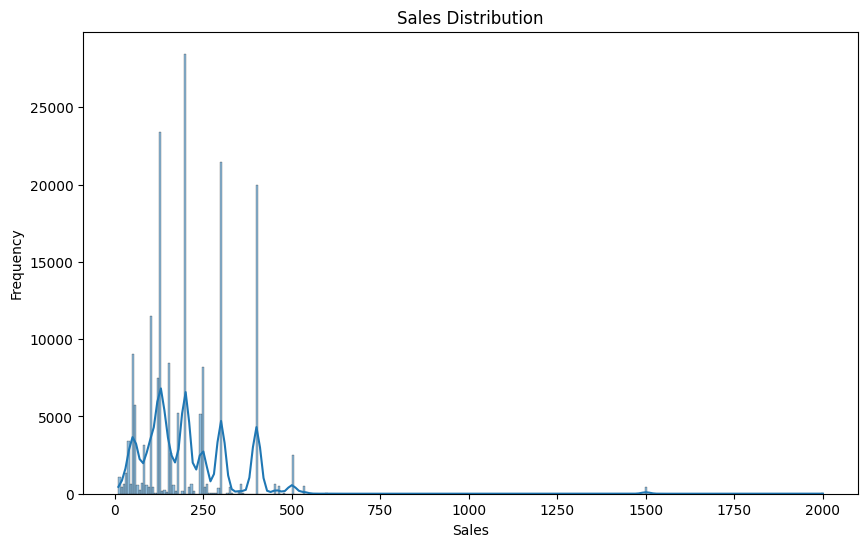

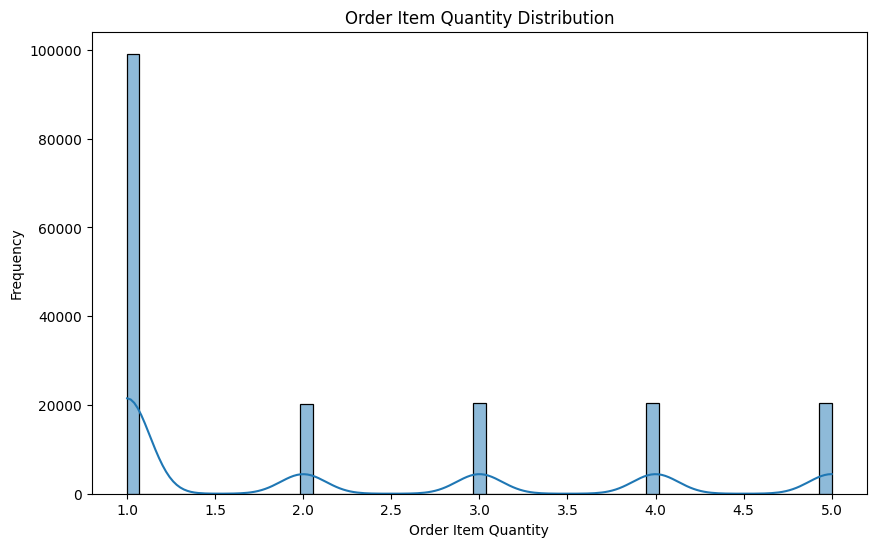

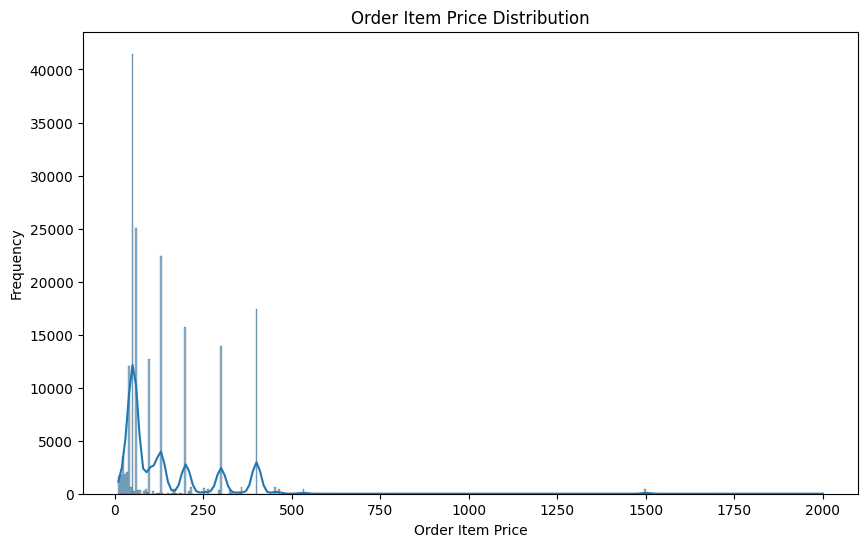

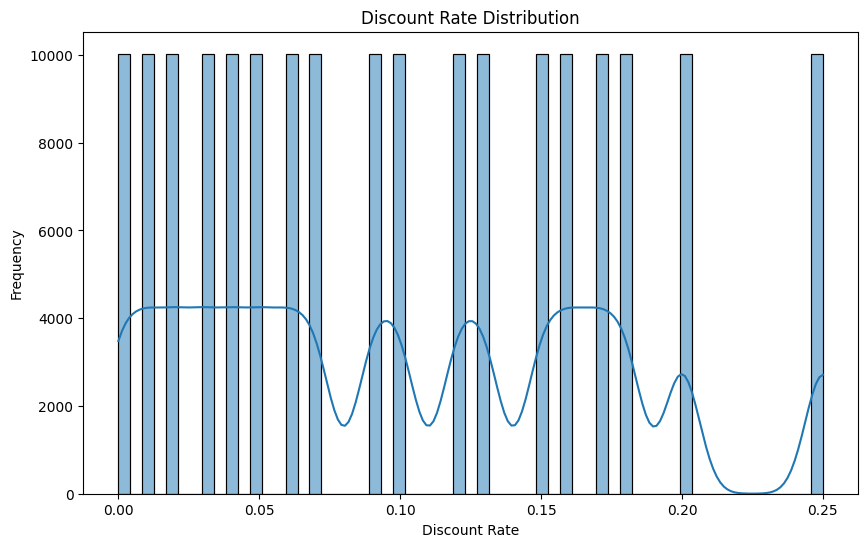

In [ ]:
# Univariate Analysis
import matplotlib.pyplot as plt
import seaborn as sns

data_pd = data.toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(data_pd['Sales'],kde = True)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()
# Order Item Quantity
plt.figure(figsize=(10, 6))
sns.histplot(data_pd['Order Item Quantity'], kde=True)
plt.title('Order Item Quantity Distribution')
plt.xlabel('Order Item Quantity')
plt.ylabel('Frequency')
plt.show()

# Order Item Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_pd['Order Item Product Price'], kde=True)
plt.title('Order Item Price Distribution')
plt.xlabel('Order Item Price')
plt.ylabel('Frequency')
plt.show()

# Discount Rate Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_pd['Order Item Discount Rate'], kde=True)
plt.title('Discount Rate Distribution')
plt.xlabel('Discount Rate')
plt.ylabel('Frequency')
plt.show()


#### 📊 Univariate Analysis

### 1. 💰 Sales Distribution
- **Shape**: Heavily **left-skewed**, clustered between **0-500**.
- **Frequency**: The most common sales value appears **~25,000 times**.
- **Outliers**: A noticeable small peak at **~1500** indicates a few high-value transactions.
- **Insight**: Products with **lower prices** are far more frequent than large transactions, suggesting a business model favoring volume over high-ticket sales.

---

### 2. 📦 Order Item Quantity
- **Shape**: Strongly **left-skewed**.
- **Observation**: Most customers **order just 1 item**, indicating **single-item purchases dominate** the dataset.
- **Insight**: Possible implications for marketing — encouraging bundle purchases or upselling could increase average order value.

---

### 3. 💵 Order Item Price
- **Shape**: Similar to sales — **left-skewed**, concentrated between **0-500**, with a **small peak near 1500**.
- **Insight**: Pricing strategy may be heavily centered on **affordable or low-priced items**, with occasional premium-priced products.

---

### 4. 🎯 Discount Rate Distribution
- **Observation**: Certain discount values occur **much more frequently** than others.
- - Most common: **5%**, **10%**, **15–20%**, followed by **25%**.
- **Insight**: Suggests a **standardized promotional strategy**, potentially influencing customer buying behavior.




### Bivariate

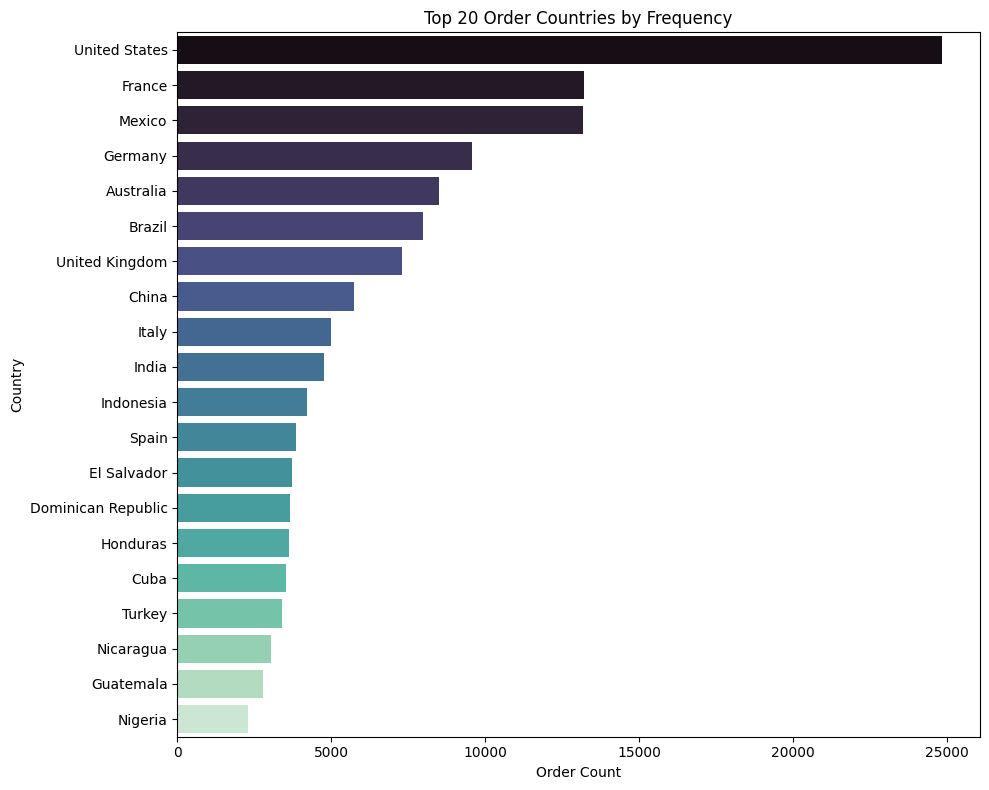

In [ ]:
# Bivariate
# Horizontal bar plot for top 20 countries
top_countries = data_pd['Order Country'].value_counts().head(20)
plt.figure(figsize=(10,8))
sns.barplot(y=top_countries.index, x=top_countries.values, palette="mako")
plt.title('Top 20 Order Countries by Frequency')
plt.xlabel('Order Count')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


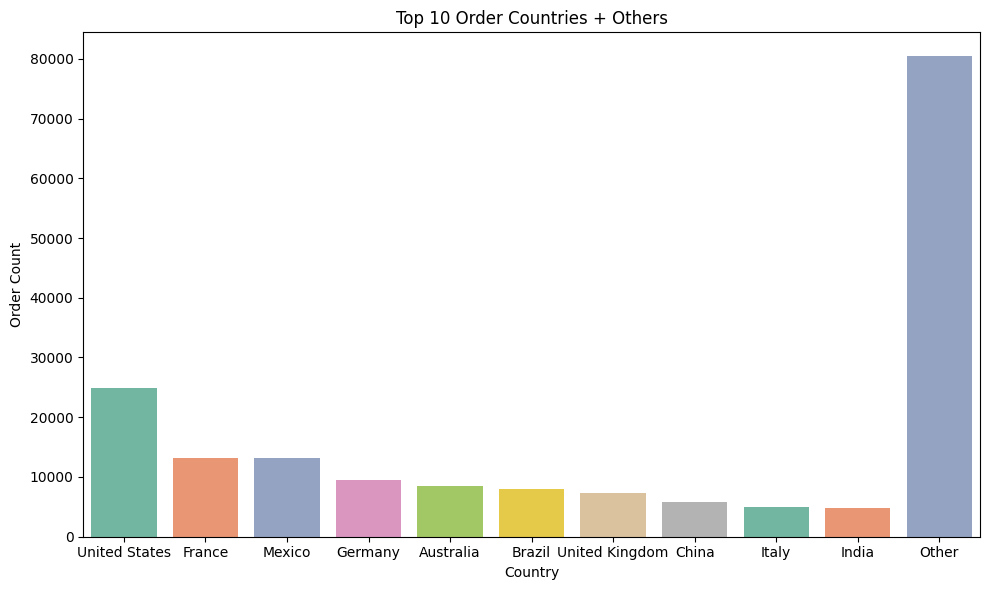

In [ ]:
# Combine lower frequency countries into 'Other'
country_counts = data_pd['Order Country'].value_counts()
top_10 = country_counts[:10]
other = pd.Series({'Other': country_counts[10:].sum()})
combined = pd.concat([top_10, other])

plt.figure(figsize=(10,6))
sns.barplot(x=combined.index, y=combined.values, palette="Set2")
plt.title('Top 10 Order Countries + Others')
plt.xlabel('Country')
plt.ylabel('Order Count')
plt.tight_layout()
plt.show()


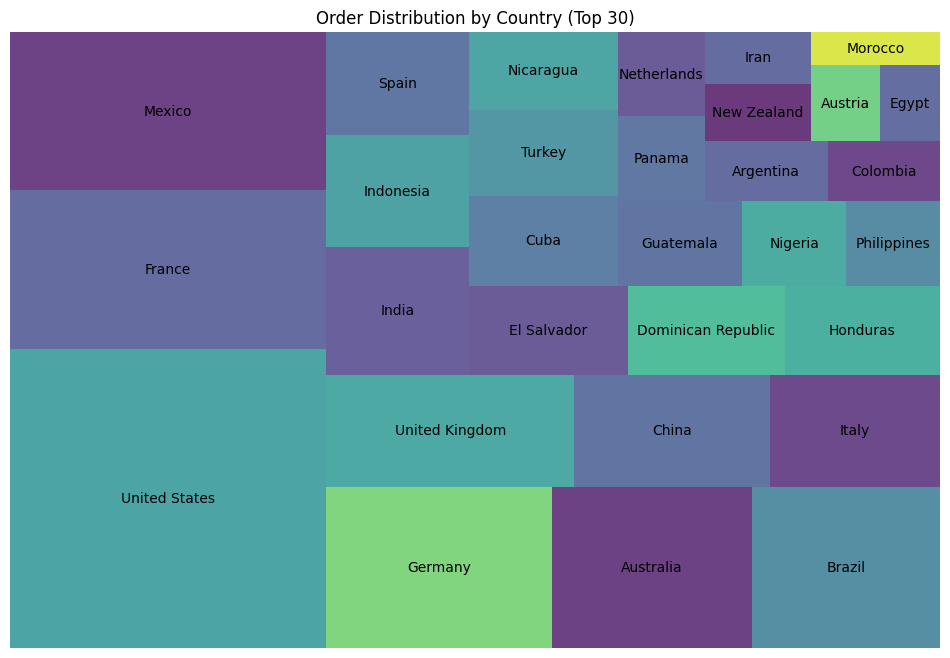

In [ ]:
!pip install squarify
import squarify

# Prepare data
country_counts = data_pd['Order Country'].value_counts().head(30)  # or all if you want

plt.figure(figsize=(12,8))
squarify.plot(sizes=country_counts.values, label=country_counts.index, alpha=0.8)
plt.axis('off')
plt.title('Order Distribution by Country (Top 30)')
plt.show()


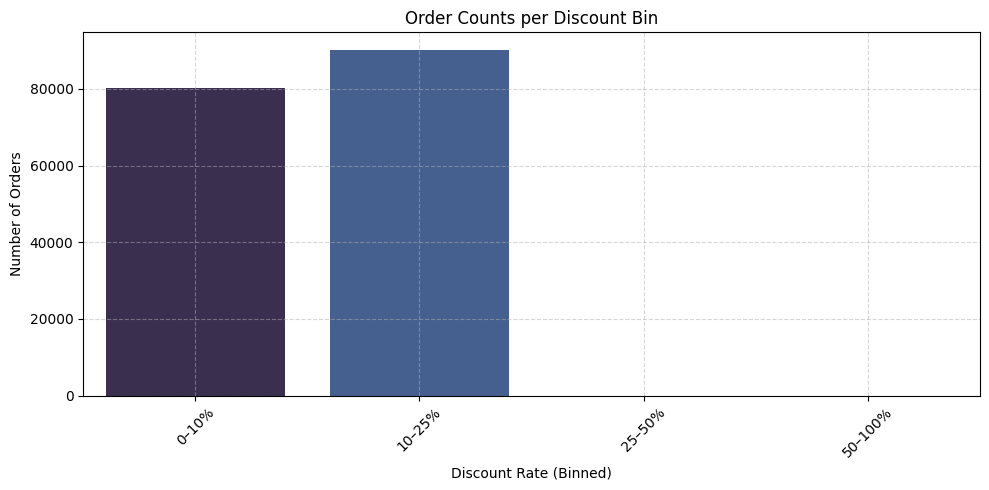

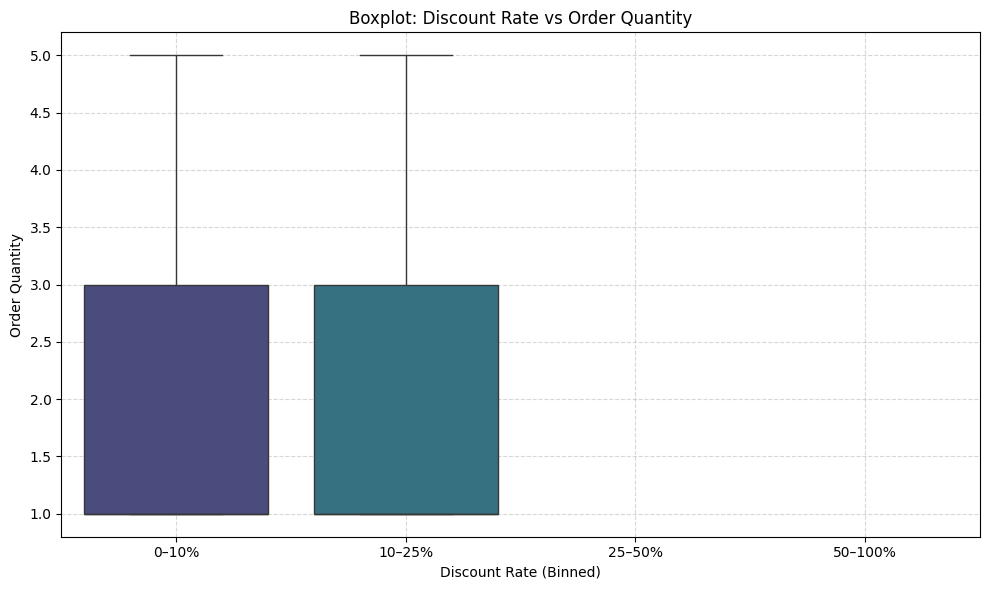

In [ ]:

# Create broader bins for discount rate
bins = [0.0, 0.1, 0.25, 0.5, 1.0]
labels = ['0–10%', '10–25%', '25–50%', '50–100%']

# Bin the 'Order Item Discount Rate'
data_pd['Discount Bin'] = pd.cut(data_pd['Order Item Discount Rate'], bins=bins, labels=labels)

# Optional: Plot count of each bin to see distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='Discount Bin', data=data_pd, palette='mako')
plt.title('Order Counts per Discount Bin')
plt.xlabel('Discount Rate (Binned)')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Filter bins that actually have data
discount_counts = data_pd['Discount Bin'].value_counts()
valid_bins = discount_counts[discount_counts > 0].index
filtered_data = data_pd[data_pd['Discount Bin'].isin(valid_bins)]

# Boxplot: Order Quantity vs Discount Bin
plt.figure(figsize=(10, 6))
sns.boxplot(x='Discount Bin', y='Order Item Quantity', data=filtered_data, palette='viridis')
plt.title('Boxplot: Discount Rate vs Order Quantity')
plt.xlabel('Discount Rate (Binned)')
plt.ylabel('Order Quantity')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

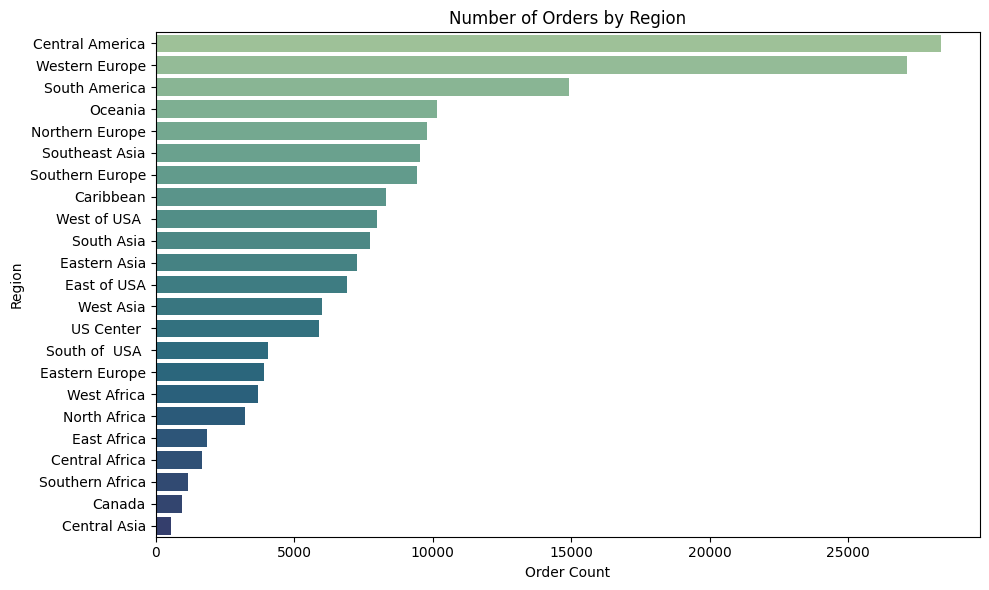

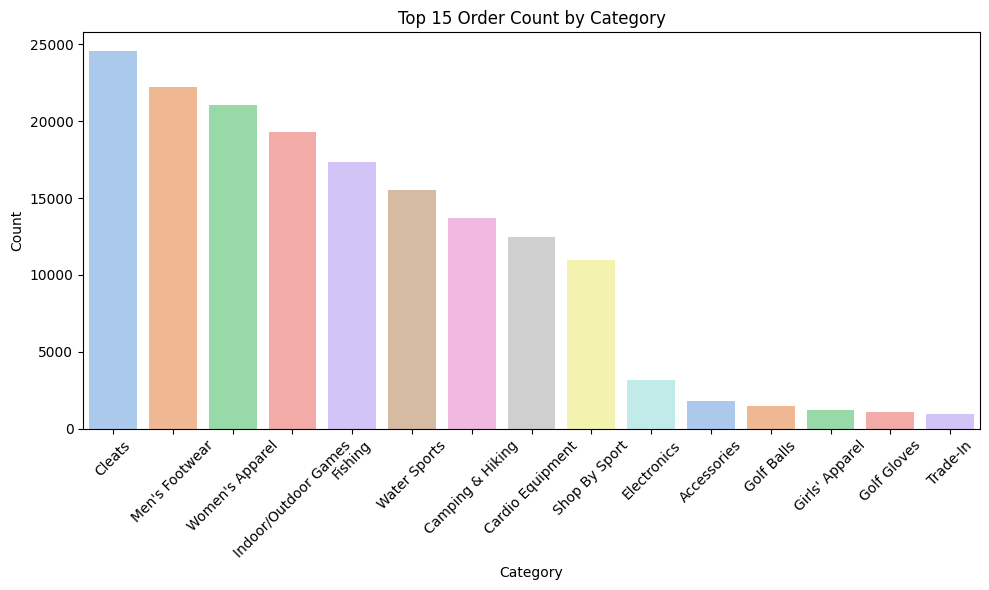

In [ ]:
# Count Plot: Orders by Region
plt.figure(figsize=(10,6))
sns.countplot(data=data_pd, y='Order Region', order=data_pd['Order Region'].value_counts().index, palette="crest")
plt.title('Number of Orders by Region')
plt.xlabel('Order Count')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

# Category
plt.figure(figsize=(10,6))
top_15_categories = data_pd['Category Name'].value_counts().head(15).index
filtered_data = data_pd[data_pd['Category Name'].isin(top_15_categories)]
sns.countplot(data=filtered_data, x='Category Name',
              order=top_15_categories, palette="pastel")
plt.xticks(rotation=45)
plt.title('Top 15 Order Count by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




#### 🌍 Order Insights by Country, Region, and Category

### 🗺️ Order Countries by Frequency
- **Top Countries**: 🇺🇸 **US**, 🇫🇷 **France**, 🇲🇽 **Mexico** are the top 3, followed by 🇩🇪 **Germany**, 🇦🇺 **Australia**, and 🇧🇷 **Brazil**.
- **Important Note**: While these top countries dominate individually, **lower-frequency countries collectively contribute nearly 4x the sales of the US**, highlighting their aggregate significance.

---

### 🎯 Discount Rate Trends
- **Range**: Discount rates span from **0% to 25%**.
- **Frequency Insight**: **10% to 25%** discounts are **more common** than **0%–10%**, suggesting active promotional strategies in this range.

---

### 🌎 Order Volume by Region
- **Top Regions**:
  - 🌴 **Central America**
  - 🌍 **Western Europe**
  - 🌎 **South America**
- These regions **dominate the number of orders**, with **order counts exceeding 1500**, marking them as major geographic contributors to sales.

---

### 🛍️ Order Count by Category
- **Top Categories**:
  - 👟 **Cleats**
  - 👞 **Men's Footwear**
  - 👗 **Women's Apparel**
- **Next Tier**: 🏀 **Indoor & Outdoor Gaming**, 🌊 **Water Sports**, 🏕️ **Camping & Hiking Equipment**, 🏃 **Cardio Equipment**, 🏅 **Shop by Sport**.
- **Insight**:
  - These top categories are likely **all-time favorites**.
  - Categories like **Water Sports** and **Camping & Hiking** might show **seasonal trends**.
  - Niches like **Golf Gloves**, **Trade-In Services**, and **Electronics** represent **rare markets**, possibly requiring different marketing strategies.



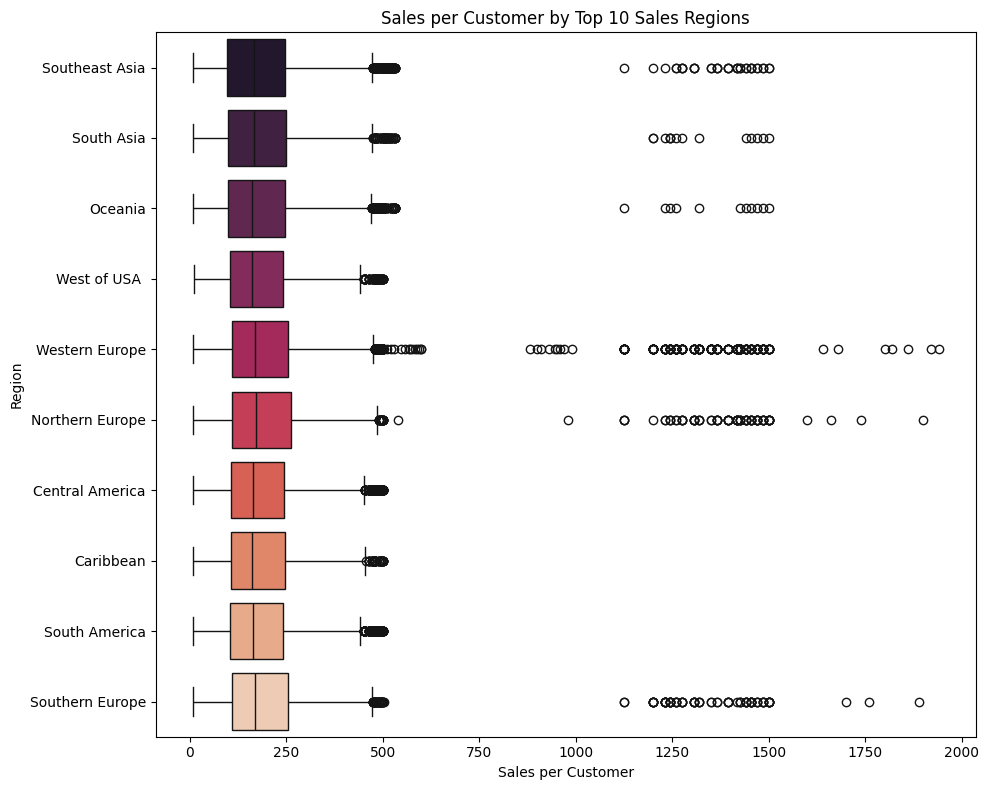

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_regions = data_pd.groupby('Order Region')['Sales per customer'].sum().sort_values(ascending=False).head(10).index

filtered_data = data_pd[data_pd['Order Region'].isin(top_regions)]
plt.figure(figsize=(10,8))
sns.boxplot(data=filtered_data, y='Order Region', x='Sales per customer', palette="rocket")
plt.title('Sales per Customer by Top 10 Sales Regions')
plt.ylabel('Region')
plt.xlabel('Sales per Customer')
plt.tight_layout()
plt.show()



#### 🧾 Analysis: Median Sales per Customer by Region

### 📊 Median Sales per Customer
- **Southeast Asia**: Highest median sales per customer, indicating customers in this region tend to spend the most on average.
- **South Asia**: Slightly lower than Southeast Asia, but still among the top.
- **Oceania**: Displays a moderate median, suggesting steady customer spending.
- **West of USA**: Similar median to Oceania.
- **Western Europe**: Lower median compared to the top regions, yet still significant.
- **Northern Europe**: Comparable to Western Europe.
- **Central America**: Lower median spending per customer.
- **Caribbean**: Similar median to Central America.
- **South America**: Also on the lower side of the spectrum.
- **Southern Europe**: Lowest median sales per customer among the top 10.

---

### 📈 Variability (IQR - Interquartile Range)
- **High Variability**:
  - **Southeast Asia** and **South Asia** show wider IQRs, suggesting a greater spread in customer spending.
- **Moderate Variability**:
  - **Oceania** and **West of USA** show noticeable but lesser variability.
- **Low Variability**:
  - **Western Europe** and **Northern Europe** exhibit compact IQRs — customer spending is more consistent.
  - **Central America**, **Caribbean**, **South America**, and **Southern Europe** also have compact IQRs, indicating tight distributions.

---

### ❗ Outliers
- All regions contain outliers, implying the presence of atypical customer spending behavior.
- **Most Outliers**:
  - **Southeast Asia** and **South Asia** — high spending variance among customers.
- **Moderate Outliers**:
  - **Western Europe** and **Northern Europe** — still show variability but less extreme.
- **Fewest Outliers**:
  - **Central America**, **Caribbean**, **South America**, and **Southern Europe** — spending is more consistent.


## **Correlation Analysis**

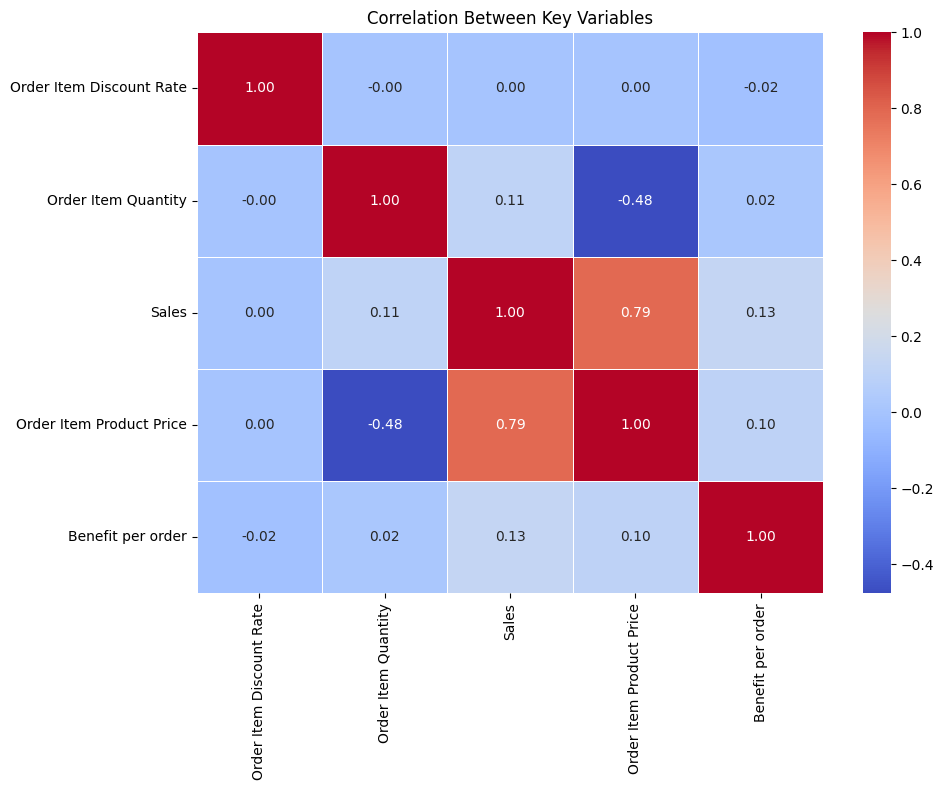

In [ ]:
# Correlation
plt.figure(figsize=(10,8))
corr = data_pd[['Order Item Discount Rate', 'Order Item Quantity', 'Sales', 'Order Item Product Price', 'Benefit per order']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Key Variables')
plt.tight_layout()
plt.show()


In [ ]:
# Select only numeric features
numeric_cols = ['Order Item Discount Rate', 'Order Item Quantity', 'Sales',
                'Sales per customer', 'Benefit per order',
                'Order Item Product Price', 'Order Item Total',
                'Order Profit Per Order']

# Create a DataFrame with only those
corr_df = data_pd[numeric_cols]

# Compute the correlation matrix
corr_matrix = corr_df.corr()


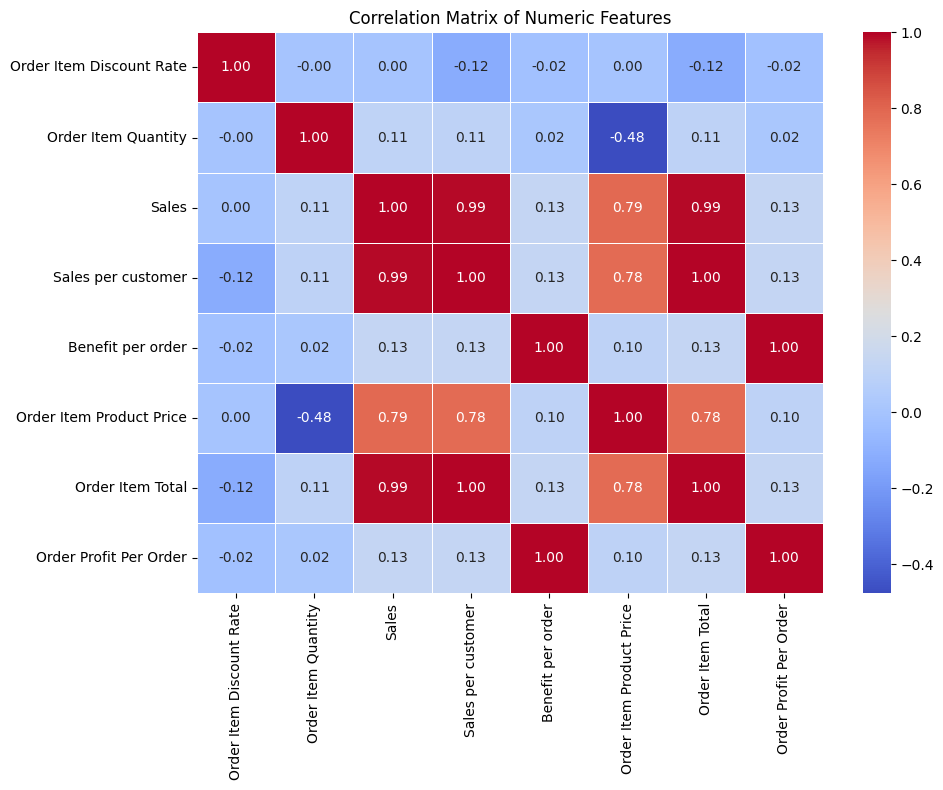

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()



####🔹 Key Findings & Implications

- **Order Item Discount Rate**  
  ➤ *Low correlation with other variables.*  
  _→ Discounts may not significantly drive sales; focus on smarter promotional strategies._

- **Order Item Quantity**  
  ➤ *Negative correlation with Product Price.*  
  _→ Lower-priced items drive volume; consider volume-based pricing._

- **Sales**  
  ➤ *Strong correlation with Sales per Customer & Order Item Total.*  
  _→ Prioritize high-value customers and order maximization._

- **Product Price**  
  ➤ *Positive with Sales, Negative with Quantity.*  
  _→ Balance premium pricing with purchase behavior through targeted campaigns._

- **Benefit per Order**  
  ➤ *Weak correlations overall.*  
  _→ Profitability is multifactorial; optimize multiple business levers._


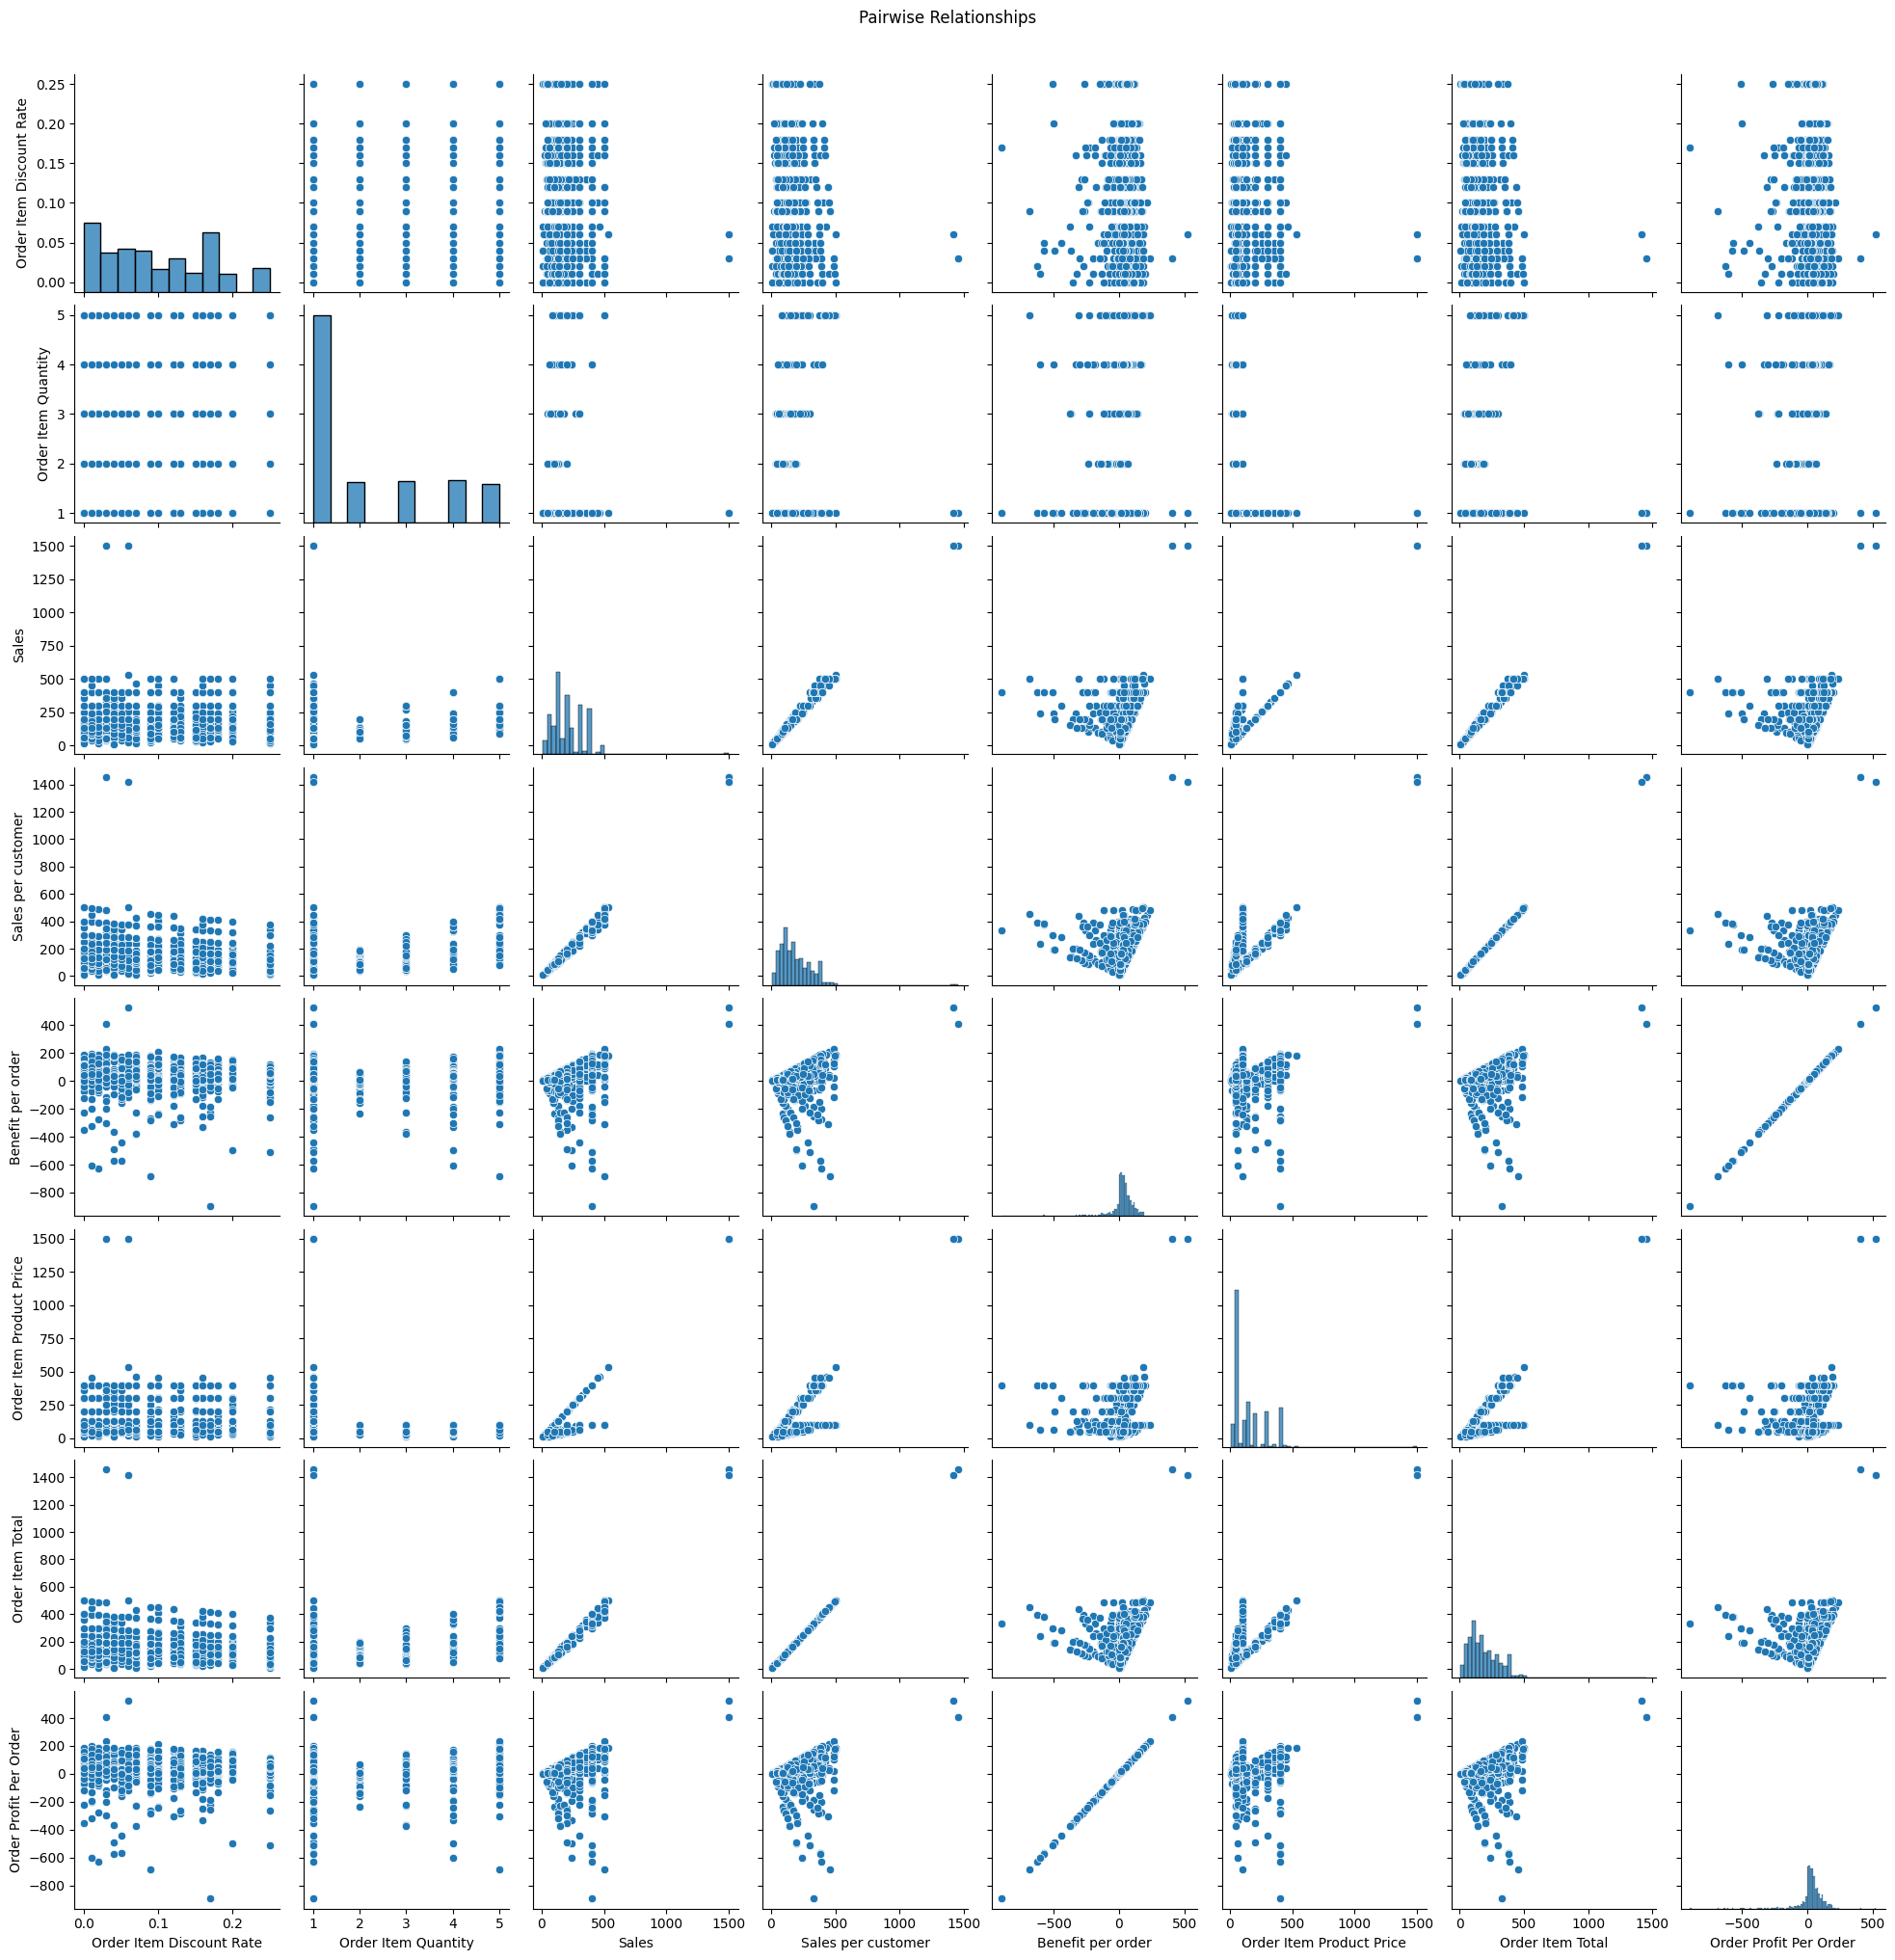

In [ ]:
sample_df = data_pd[numeric_cols].sample(1000, random_state=42)

sns.pairplot(sample_df)
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()


#### 🔍 Correlation Summary

#### 📈 Sales & Order Item Total  
A strong positive correlation indicates that higher sales generally lead to higher total order values.

---

#### 📉 Order Item Quantity & Product Price  
A negative correlation suggests that as the quantity ordered increases, the product price tends to decrease—likely due to bulk discounts.

---

#### 🎯 Order Item Discount Rate  
Shows little to no correlation with other variables, indicating discount rates may not significantly influence key metrics like sales or quantity.

    


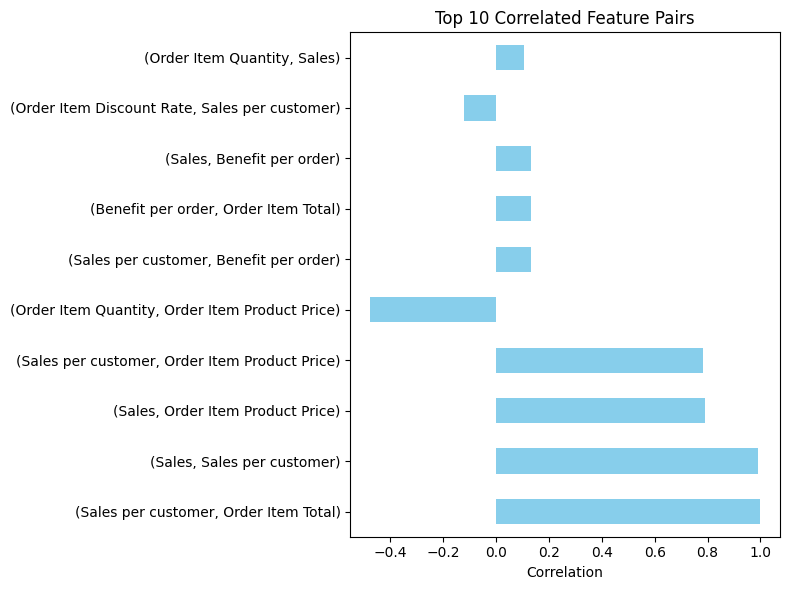

In [ ]:
# Flatten and sort the correlation pairs
corr_pairs = corr_matrix.unstack()
# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
# Drop duplicate pairs
corr_pairs = corr_pairs.drop_duplicates().sort_values(key=lambda x: abs(x), ascending=False)

# Take top 10
top_corrs = corr_pairs[:10]

# Barplot
top_corrs.plot(kind='barh', figsize=(8,6), color='skyblue')
plt.title("Top 10 Correlated Feature Pairs")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()


#### 💸 Sales and Customer Metrics  
If you can get each customer to spend more (increase sales per customer), your total sales and order values will go up significantly. So, it's smart to focus on strategies that encourage customers to buy more.

---

#### 📊 Pricing Strategy  
Expensive products bring in more money, but people tend to buy fewer of them. So, there's a trade-off—pricing things higher boosts revenue, but might reduce the quantity sold.

---

#### 🏷️ Discount Strategy  
Giving discounts doesn’t seem to make a big difference in boosting sales. **SO DISCOUNT HAS NO EFFECT ON SALES**

---

#### 📈 Benefit per Order  
Orders with higher total value and sales tend to give more profit. So boosting those metrics will naturally increase how much you benefit from each order.

---

#### 📦 Quantity and Pricing  
People tend to buy more when the price is lower—probably due to bulk deals. **Offering volume discounts might get more items sold, even if the profit per item is smaller.**


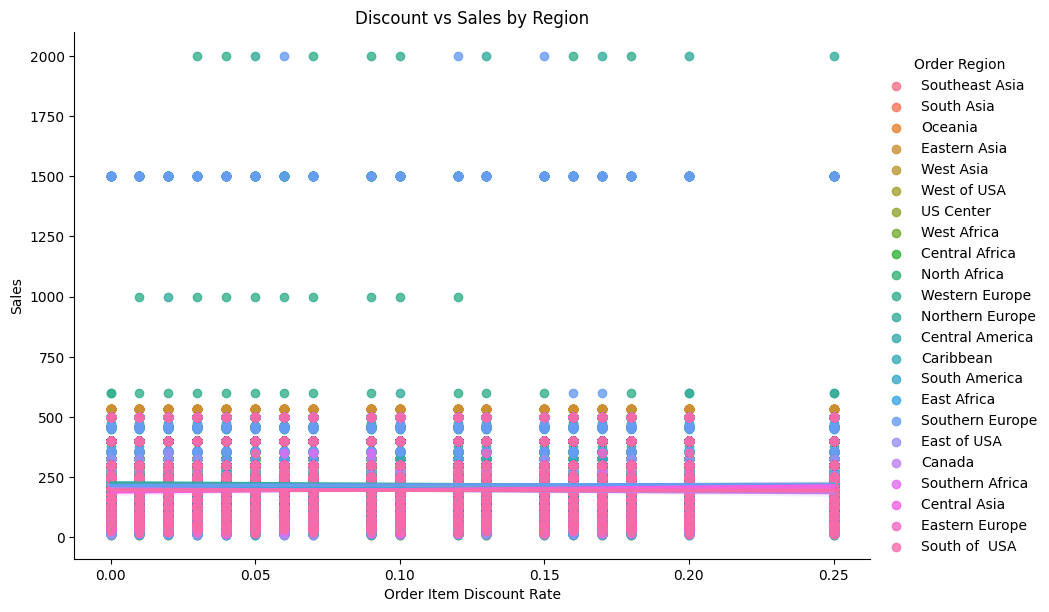

In [ ]:
# comparing discount vs. sales across regions
sns.lmplot(data=data_pd, x='Order Item Discount Rate', y='Sales', hue='Order Region', height=6, aspect=1.5)
plt.title("Discount vs Sales by Region")
plt.show()

 🔍 **Observations**
- **Sales Distribution**: Sales happen across all kinds of discount rates, and the numbers vary a lot.
- **Regional Differences**: Different regions show different patterns—some regions have high sales with certain discount rates.
- **Discount Impact**: There's no clear overall pattern between discounts and sales, meaning it depends on the region.

---

 💡 **Implications**

- **Regional Strategies**: Each region might need its own discount strategy to match how customers behave there.
- **Market Differences**: What works in one place might not work in another, so it’s important to understand each region’s market.
- **Better Decisions**: This view helps spot where and how discounts work, so strategies can be smarter and more focused.

---

✅ **Conclusion**

Discounts affect sales differently in each region. One-size-fits-all doesn't work—regional insights are key for better pricing and marketing.


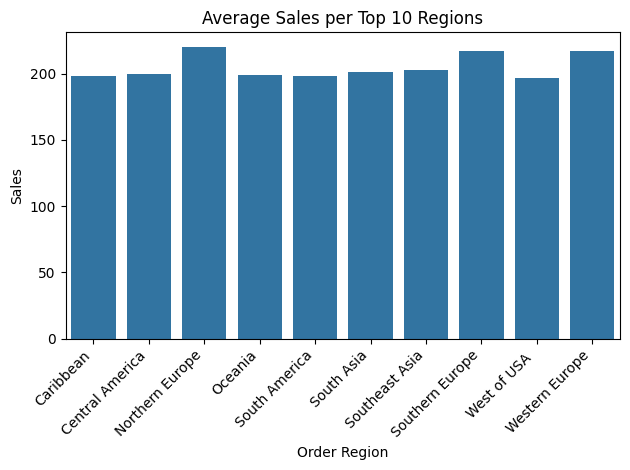

In [ ]:
# Calculate total sales per region
region_sales = data_pd.groupby("Order Region")["Sales"].sum().reset_index()

# Get top N regions (e.g., top 10)
top_regions = region_sales.sort_values(by="Sales", ascending=False).head(10)["Order Region"].tolist()

# Filter data to include only top regions
filtered_data = data_pd[data_pd["Order Region"].isin(top_regions)]

# Group and calculate mean discount and sales for top regions
region_group = filtered_data.groupby("Order Region")[["Order Item Discount Rate", "Sales"]].mean().reset_index()
region_group = region_group.rename(columns={"Order Item Discount Rate": "Discount"})

# Plot the barplot for top regions
sns.barplot(data=region_group, x="Order Region", y="Sales")
plt.title("Average Sales per Top 10 Regions")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

📊 **Average Sales by Top 10 Regions**

This bar chart shows how much each region is selling on average.

---

🔍 What We See

- **Top Sellers**:
  - *Northern Europe* sells the most, just above 225 units.
  - *Southern and Western Europe* follow closely behind.

- **Middle Performers**:
  - *Oceania* and *South Asia* do pretty well, just under 200.
  - *Central America*, *South America*, *Southeast Asia*, and *West of USA* are in the middle range.

- **Lowest Seller**:
  - *Caribbean* has the lowest average sales among the top 10.

---

### 💡 What It Means

- **Strong Regions**: Europe (North, South, West) is doing great. These regions likely have better marketing, stronger demand, or more loyal customers.

- **Improve the Rest**: Regions like the Caribbean and Central/South America may need better ads, new products, or more focus on customer needs.

- **Smart Spending**: Knowing where sales are strong helps decide where to invest more or where to make changes.

- **Know Your Markets**: Every region is different. Studying what works in one place can help improve sales in others.

- **Copy Success**: Learn from top regions to improve performance in others.

- **Personalized Plans**: Divide customers by region to create marketing and products that fit their taste.

---

### ✅ Summary

This chart gives a quick view of where sales are good and where there's room to grow. It helps plan better strategies for each region.


### **Correlation Final Suggesions**

1. Consider Volume-based pring
2. Product price increases Quantity decreases -> high price stuff is rarely bought
3. order item quantity increases when price decreases -> obvious but likeley due to discounts or bulk deals , offering volume discounts might get more items sold even if profit per item is low.
4. discount rates has no correlation with anything implying that they are ineffective
5. Some regions have high sales with certain discount rates -> each region might need it's own discount strategy

In [ ]:
# EMPTY CELL 😂

# **Modelling**


## **Feature Engineerinng**

In [ ]:
data_pd.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Segment', 'Customer State',
       'Department Name', 'Market', 'Order City', 'Order Country',
       'order date (DateOrders)', 'Order Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Order Status', 'Product Price', 'Product Status',
       'shipping date (DateOrders)', 'Shipping Mode', 'Discount Bin'],
      dtype='object')

In [ ]:
data.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+--------------+--------------+----------------+----------------+--------------+---------------+------------+----------+-------------+-----------------------+--------+-------------------+------------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk| Category Name| Customer City|Customer Country|Customer Segment|Customer State|Department Name|      Market|Order City|Order Country|order date (DateOrders)|Order Id|Order Item Discount|Order Item Discount Rate|Order Item Product Price|Order Item Profit Ratio|Order Item 

In [ ]:
# Feature Engineering
from pyspark.sql.functions import col, round, when

# Avoid division by zero when calculating profit per item
data = data.withColumn(
    "profit_per_item",
    when(col("Order Item Quantity") != 0, col("Order Profit Per Order") / col("Order Item Quantity")).otherwise(0)
)

# Total Order Value: Quantity * Product Price
data = data.withColumn(
    "total_order_value",
    col("Order Item Quantity") * col("Order Item Product Price")
)

# Discount Amount: Discount Rate * Product Price
data = data.withColumn(
    "discount_amount",
    col("Order Item Discount Rate") * col("Order Item Product Price")
)

# Profit Margin: Profit per item / Product Price
data = data.withColumn(
    "profit_margin",
    when(col("Order Item Product Price") != 0,
         round(col("profit_per_item") / col("Order Item Product Price"), 2)
    ).otherwise(0)
)

# Show results
data.select(
    "Order Item Quantity",
    "Order Item Product Price",
    "Order Item Discount Rate",
    "Order Profit Per Order",
    "profit_per_item",
    "total_order_value",
    "discount_amount",
    "profit_margin"
).show()

+-------------------+------------------------+------------------------+----------------------+---------------+-----------------+------------------+-------------+
|Order Item Quantity|Order Item Product Price|Order Item Discount Rate|Order Profit Per Order|profit_per_item|total_order_value|   discount_amount|profit_margin|
+-------------------+------------------------+------------------------+----------------------+---------------+-----------------+------------------+-------------+
|                  1|                  327.75|             0.039999999|                 91.25|          91.25|           327.75|    13.10999967225|         0.28|
|                  1|                  327.75|             0.050000001|          -249.0899963|   -249.0899963|           327.75|    16.38750032775|        -0.76|
|                  1|                  327.75|             0.059999999|          -247.7799988|   -247.7799988|           327.75|19.664999672249998|        -0.76|
|                  1|       

In [ ]:
data.columns

['Type',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Sales per customer',
 'Delivery Status',
 'Late_delivery_risk',
 'Category Name',
 'Customer City',
 'Customer Country',
 'Customer Segment',
 'Customer State',
 'Department Name',
 'Market',
 'Order City',
 'Order Country',
 'order date (DateOrders)',
 'Order Id',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'Order Item Total',
 'Order Profit Per Order',
 'Order Region',
 'Order State',
 'Order Status',
 'Product Price',
 'Product Status',
 'shipping date (DateOrders)',
 'Shipping Mode',
 'profit_per_item',
 'total_order_value',
 'discount_amount',
 'profit_margin']

**Feature Engineering Based on Regions**

In [ ]:
from pyspark.sql.functions import (
    col, avg, sum, countDistinct, year, month, to_date,
    when, datediff
)

# 1. Convert Dates
data = data.withColumn("order_date", to_date(col("order date (DateOrders)")))
data = data.withColumn("shipping_date", to_date(col("shipping date (DateOrders)")))

# 2. Extract Year/Month & Create Helper Columns
data = data.withColumn("year", year(col("order_date")))
data = data.withColumn("month", month(col("order_date")))
data = data.withColumn("shipping_time", datediff(col("shipping_date"), col("order_date")))
data = data.withColumn("has_discount", when(col("Order Item Discount Rate") > 0, 1).otherwise(0))
data = data.withColumn("on_time_delivery", when(col("Delivery Status") == "On Time", 1).otherwise(0))

# 3. Region-Specific Aggregations

# 📈 Sales Performance
region_sales = data.groupBy("Order Region").agg(
    avg("Sales").alias("avg_sales_per_region"),
    sum("Sales").alias("total_sales_per_region"),
    countDistinct("Order Id").alias("orders_per_region")
)

# 🎯 Discount Effectiveness
region_discount = data.groupBy("Order Region").agg(
    avg("Order Item Discount Rate").alias("avg_discount_rate_per_region")
)

discount_frequency = data.groupBy("Order Region").agg(
    avg("has_discount").alias("discount_frequency_per_region")
)

# 👥 Customer Behavior
region_behavior = data.groupBy("Order Region").agg(
    avg("Order Item Quantity").alias("avg_order_quantity_per_region"),
    avg("total_order_value").alias("avg_order_value_per_region")
)

# 🚚 Operational Metrics
region_shipping = data.groupBy("Order Region").agg(
    avg("shipping_time").alias("avg_shipping_time_per_region")
)

region_delivery = data.groupBy("Order Region").agg(
    avg("on_time_delivery").alias("delivery_performance_per_region"),
    avg("Late_delivery_risk").alias("avg_late_delivery_risk_per_region")
)

# 4. Merge All Region-Based Aggregations
data = data.join(region_sales, on="Order Region", how="left") \
           .join(region_discount, on="Order Region", how="left") \
           .join(discount_frequency, on="Order Region", how="left") \
           .join(region_behavior, on="Order Region", how="left") \
           .join(region_shipping, on="Order Region", how="left") \
           .join(region_delivery, on="Order Region", how="left")

# 5. Final Output
data.show(5)


+--------------+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+--------------+-------------+----------------+----------------+--------------+---------------+------------+----------+-------------+-----------------------+--------+-------------------+------------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+---------------+---------------+-------------+--------------+--------------------------+--------------+---------------+-----------------+------------------+-------------+----------+-------------+----+-----+-------------+------------+----------------+--------------------+----------------------+-----------------+----------------------------+-----------------------------+-----------------------------+--------------------------+----------------------------+-------------------------------+--------------------------------

In [ ]:
data.columns

['Order Region',
 'Type',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Sales per customer',
 'Delivery Status',
 'Late_delivery_risk',
 'Category Name',
 'Customer City',
 'Customer Country',
 'Customer Segment',
 'Customer State',
 'Department Name',
 'Market',
 'Order City',
 'Order Country',
 'order date (DateOrders)',
 'Order Id',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'Order Item Total',
 'Order Profit Per Order',
 'Order State',
 'Order Status',
 'Product Price',
 'Product Status',
 'shipping date (DateOrders)',
 'Shipping Mode',
 'profit_per_item',
 'total_order_value',
 'discount_amount',
 'profit_margin',
 'order_date',
 'shipping_date',
 'year',
 'month',
 'shipping_time',
 'has_discount',
 'on_time_delivery',
 'avg_sales_per_region',
 'total_sales_per_region',
 'orders_per_region',
 'avg_discount_rate_per_region',
 'discount_freq

In [ ]:
from pyspark.sql.functions import col

# Define the relevant features for modeling
selected_features = [
    # Region and performance metrics
    'Order Region',
    'avg_sales_per_region',
    'total_sales_per_region',
    'orders_per_region',
    'avg_discount_rate_per_region',
    'discount_frequency_per_region',
    'avg_order_quantity_per_region',
    'avg_order_value_per_region',
    'avg_shipping_time_per_region',
    'delivery_performance_per_region',
    'avg_late_delivery_risk_per_region',

    # Discount and sales-related
    'Sales',
    'Order Item Discount',
    'Order Item Discount Rate',
    'Order Item Total',
    'Order Item Product Price',
    'Product Price',
    'discount_amount',
    'has_discount',
    'profit_per_item',
    'total_order_value',
    'profit_margin',
    'Order Item Quantity',

    # Order/Shipping timing
    'order_date',
    'shipping_date',
    'shipping_time',
    'on_time_delivery',
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Late_delivery_risk',

    # Optional temporal features
    'year',
    'month',
    'Shipping Mode'
]

# Keep only the selected features
data = data.select([col(c) for c in selected_features])


In [ ]:
data

DataFrame[Order Region: string, avg_sales_per_region: double, total_sales_per_region: double, orders_per_region: bigint, avg_discount_rate_per_region: double, discount_frequency_per_region: double, avg_order_quantity_per_region: double, avg_order_value_per_region: double, avg_shipping_time_per_region: double, delivery_performance_per_region: double, avg_late_delivery_risk_per_region: double, Sales: double, Order Item Discount: double, Order Item Discount Rate: double, Order Item Total: double, Order Item Product Price: double, Product Price: double, discount_amount: double, has_discount: int, profit_per_item: double, total_order_value: double, profit_margin: double, Order Item Quantity: int, order_date: date, shipping_date: date, shipping_time: int, on_time_delivery: int, Days for shipping (real): int, Days for shipment (scheduled): int, Late_delivery_risk: int, year: int, month: int, Shipping Mode: string]

In [ ]:
data.show()

+--------------+--------------------+----------------------+-----------------+----------------------------+-----------------------------+-----------------------------+--------------------------+----------------------------+-------------------------------+---------------------------------+------+-------------------+------------------------+----------------+------------------------+-------------+------------------+------------+---------------+-----------------+-------------+-------------------+----------+-------------+-------------+----------------+------------------------+-----------------------------+------------------+----+-----+--------------+
|  Order Region|avg_sales_per_region|total_sales_per_region|orders_per_region|avg_discount_rate_per_region|discount_frequency_per_region|avg_order_quantity_per_region|avg_order_value_per_region|avg_shipping_time_per_region|delivery_performance_per_region|avg_late_delivery_risk_per_region| Sales|Order Item Discount|Order Item Discount Rate|Order

In [ ]:
# prompt: drop order_data, shipping_date, shipping_time, year, month, avg_shipping_time_per_region,

data = data.drop("order_data", "shipping_date", "shipping_time", "year", "month", "avg_shipping_time_per_region")


In [ ]:
data.columns

['Order Region',
 'avg_sales_per_region',
 'total_sales_per_region',
 'orders_per_region',
 'avg_discount_rate_per_region',
 'discount_frequency_per_region',
 'avg_order_quantity_per_region',
 'avg_order_value_per_region',
 'delivery_performance_per_region',
 'avg_late_delivery_risk_per_region',
 'Sales',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Total',
 'Order Item Product Price',
 'Product Price',
 'discount_amount',
 'has_discount',
 'profit_per_item',
 'total_order_value',
 'profit_margin',
 'Order Item Quantity',
 'order_date',
 'on_time_delivery',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Late_delivery_risk',
 'Shipping Mode']

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType

# Step 1: Cast all numerical columns to DoubleType
numeric_cols = [
    'avg_sales_per_region',
    'total_sales_per_region',
    'orders_per_region',
    'avg_discount_rate_per_region',
    'discount_frequency_per_region',
    'avg_order_quantity_per_region',
    'avg_order_value_per_region',
    'delivery_performance_per_region',
    'avg_late_delivery_risk_per_region',
    'Sales',
    'Order Item Discount',
    'Order Item Discount Rate',
    'Order Item Total',
    'Order Item Product Price',
    'Product Price',
    'discount_amount',
    'has_discount',
    'profit_per_item',
    'total_order_value',
    'Order Item Quantity',
    'on_time_delivery',
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Late_delivery_risk'
]

for col_name in numeric_cols:
    data = data.withColumn(col_name, col(col_name).cast(DoubleType()))

# Step 2: Index categorical columns
indexers = [
    StringIndexer(inputCol='Order Region', outputCol='Order_Region_Index', handleInvalid="keep"),
    StringIndexer(inputCol='Shipping Mode', outputCol='Shipping_Mode_Index', handleInvalid="keep")
]

# Step 3: Define feature columns
feature_cols = numeric_cols + ['Order_Region_Index', 'Shipping_Mode_Index']

# Step 4: Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Step 5: Pipeline and transform
pipeline = Pipeline(stages=indexers + [assembler])
data_prepared = pipeline.fit(data).transform(data)


In [ ]:
data.select([col(c).cast(DoubleType()).alias(c) for c in numeric_cols]).printSchema()


root
 |-- avg_sales_per_region: double (nullable = true)
 |-- total_sales_per_region: double (nullable = true)
 |-- orders_per_region: double (nullable = true)
 |-- avg_discount_rate_per_region: double (nullable = true)
 |-- discount_frequency_per_region: double (nullable = true)
 |-- avg_order_quantity_per_region: double (nullable = true)
 |-- avg_order_value_per_region: double (nullable = true)
 |-- delivery_performance_per_region: double (nullable = true)
 |-- avg_late_delivery_risk_per_region: double (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Order Item Discount: double (nullable = true)
 |-- Order Item Discount Rate: double (nullable = true)
 |-- Order Item Total: double (nullable = true)
 |-- Order Item Product Price: double (nullable = true)
 |-- Product Price: double (nullable = true)
 |-- discount_amount: double (nullable = true)
 |-- has_discount: double (nullable = false)
 |-- profit_per_item: double (nullable = true)
 |-- total_order_value: double (nullable

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Split the data
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)

# Define the model
rf = RandomForestRegressor(featuresCol="features", labelCol="profit_margin")

# Fit the model
rf_model = rf.fit(train_data)

# Predict on test set
predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(
    labelCol="profit_margin",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
print(f"Test RMSE: {rmse}")


Test RMSE: 0.1953548087153207


In [ ]:
from pyspark.sql.functions import explode, array, lit

# Define discount rates to simulate
discount_rates = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

# Duplicate rows for each discount rate
exploded = data.withColumn("simulated_discount", explode(array([lit(x) for x in discount_rates])))

# Recalculate dependent columns
exploded = exploded \
    .withColumn("Order Item Discount", col("simulated_discount") * col("Product Price")) \
    .withColumn("discount_amount", col("Order Item Discount")) \
    .withColumn("Order Item Discount Rate", col("simulated_discount")) \
    .withColumn("Order Item Total", (col("Product Price") - col("Order Item Discount")) * col("Order Item Quantity")) \
    .withColumn("profit_per_item", (col("Product Price") * 0.2) - col("Order Item Discount")) \
    .withColumn("profit_margin", (col("profit_per_item") * col("Order Item Quantity")) / col("Order Item Total"))


In [ ]:
# Apply the same preprocessing pipeline
sim_prepared = pipeline.fit(data).transform(exploded)

# Predict profit margin for each simulated discount
sim_predictions = rf_model.transform(sim_prepared)


In [ ]:
sim_predictions.columns


['Order Region',
 'avg_sales_per_region',
 'total_sales_per_region',
 'orders_per_region',
 'avg_discount_rate_per_region',
 'discount_frequency_per_region',
 'avg_order_quantity_per_region',
 'avg_order_value_per_region',
 'delivery_performance_per_region',
 'avg_late_delivery_risk_per_region',
 'Sales',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Total',
 'Order Item Product Price',
 'Product Price',
 'discount_amount',
 'has_discount',
 'profit_per_item',
 'total_order_value',
 'profit_margin',
 'Order Item Quantity',
 'order_date',
 'on_time_delivery',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Late_delivery_risk',
 'Shipping Mode',
 'simulated_discount',
 'Order_Region_Index',
 'Shipping_Mode_Index',
 'features',
 'prediction']

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id, row_number, desc
from pyspark.sql.window import Window

# Add unique row ID if not already present
if "row_id" not in sim_predictions.columns:
    sim_predictions = sim_predictions.withColumn("row_id", monotonically_increasing_id())

# Define a window to find the best discount per original row
window = Window.partitionBy("row_id").orderBy(desc("prediction"))

# Select the best discount (i.e., highest predicted profit_margin)
best_discounts = sim_predictions.withColumn("rank", row_number().over(window)) \
                                .filter(col("rank") == 1)

# Select relevant columns
final_recommendations = best_discounts.select(
    "row_id",
    "simulated_discount",
    "prediction"
).withColumnRenamed("simulated_discount", "recommended_discount_rate") \
 .withColumnRenamed("prediction", "expected_profit_margin")

final_recommendations.show(truncate=False)


+------+-------------------------+----------------------+
|row_id|recommended_discount_rate|expected_profit_margin|
+------+-------------------------+----------------------+
|0     |0.0                      |0.25520400850542246   |
|1     |0.05                     |0.2616211812750929    |
|5     |0.25                     |-0.25119497272198     |
|6     |0.3                      |-0.2931509131559181   |
|7     |0.0                      |0.23960524847951517   |
|9     |0.1                      |0.23373869744416673   |
|10    |0.15                     |0.17925500617891635   |
|17    |0.15                     |0.18738636887362134   |
|19    |0.25                     |-0.26305585392606584  |
|22    |0.05                     |0.2607144929997914    |
|25    |0.2                      |0.12219646671573173   |
|26    |0.25                     |-0.24795648586135868  |
|27    |0.3                      |-0.327377248909811    |
|28    |0.0                      |0.2431546264062138    |
|29    |0.05  

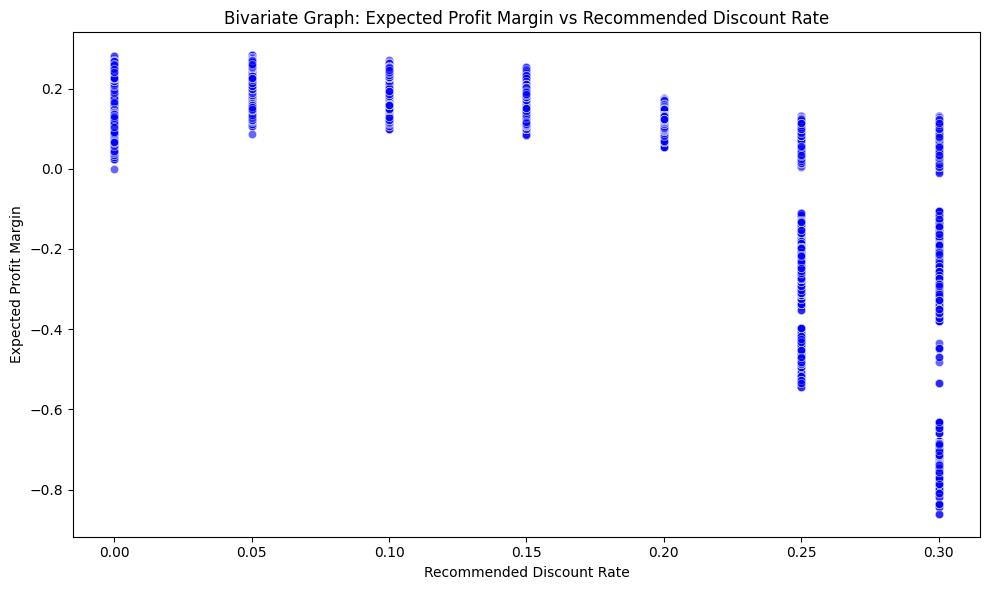

In [ ]:
# 1. Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Convert to Pandas
final_recommendations_pd = final_recommendations.toPandas()

# 3. Set up the plot
plt.figure(figsize=(10, 6))

# 4. Plot the bivariate scatter plot
sns.scatterplot(data=final_recommendations_pd,
                x='recommended_discount_rate',
                y='expected_profit_margin',
                color='blue',
                alpha=0.6)

# 5. Add titles and labels
plt.title("Bivariate Graph: Expected Profit Margin vs Recommended Discount Rate")
plt.xlabel("Recommended Discount Rate")
plt.ylabel("Expected Profit Margin")

# 6. Show plot
plt.tight_layout()
plt.show()


In [ ]:
# Check the schema of the final_recommendations dataframe to confirm column names
final_recommendations.printSchema()

root
 |-- row_id: long (nullable = false)
 |-- recommended_discount_rate: double (nullable = false)
 |-- expected_profit_margin: double (nullable = false)

